In [ ]:
import os
import os.path
import pickle
import time
import shelve

import chainer
from chainer import cuda
from chainer import serializers
import chainer.optimizers as O
import numpy as np

from lda2vec_old import utils
from lda2vec_old import prepare_topics, print_top_words_per_topic, topic_coherence
from lda2vec_model import LDA2Vec

gpu_id = int(os.getenv('CUDA_GPU', 0))
cuda.get_device(gpu_id).use()
print "Using GPU " + str(gpu_id)



## Loading pretrained topic vectors

In [ ]:
factors = np.load("final/factors.npy")

# Hyper parameters and training

In [ ]:
n_docs = doc_ids.max() + 1
# Number of unique words in the vocabulary
n_vocab = flattened.max() + 1
# 'Strength' of the dircihlet prior; 200.0 seems to work well
clambda = 200.0
# Number of topics to fit
n_topics = int(os.getenv('n_topics', 20))
batchsize = 4096
# Power for neg sampling
power = float(os.getenv('power', 0.75))
# Intialize with pretrained word vectors
pretrained = bool(int(os.getenv('pretrained', True)))
# Sampling temperature
temperature = float(os.getenv('temperature', 1.0))
# Number of dimensions in a single word vector
n_units = int(os.getenv('n_units', 300))
# Get the string representation for every compact key
words = corpus.word_list(vocab)[:n_vocab]
# How many tokens are in each document
doc_idx, lengths = np.unique(doc_ids, return_counts=True)
doc_lengths = np.zeros(doc_ids.max() + 1, dtype='int32')
doc_lengths[doc_idx] = lengths
# Count all token frequencies
tok_idx, freq = np.unique(flattened, return_counts=True)
term_frequency = np.zeros(n_vocab, dtype='int32')
term_frequency[tok_idx] = freq

for key in sorted(locals().keys()):
    val = locals()[key]
    if len(str(val)) < 100 and '<' not in str(val):
        print key, val

model = LDA2Vec(n_documents=n_docs, n_document_topics=n_topics,
                n_units=n_units, n_vocab=n_vocab, counts=term_frequency,
                n_samples=15, power=power, temperature=temperature)
# if os.path.exists('lda2vec.hdf5'):
#     print "Reloading from saved"
#     serializers.load_hdf5("lda2vec.hdf5", model)
if pretrained:
    model.sampler.W.data[:, :] = vectors[:n_vocab, :]
model.mixture.factors.W.data = factors.astype(np.float32)
model.to_gpu()
optimizer = O.Adam()
optimizer.setup(model)
clip = chainer.optimizer.GradientClipping(5.0)
optimizer.add_hook(clip)

j = 0
epoch = 0
fraction = batchsize * 1.0 / flattened.shape[0]
loss_ep=[]
#progress = shelve.open('progress.shelve')
for epoch in range(200):
    data = prepare_topics(cuda.to_cpu(model.mixture.weights.W.data).copy(),
                          cuda.to_cpu(model.mixture.factors.W.data).copy(),
                          cuda.to_cpu(model.sampler.W.data).copy(),
                          words)
    top_words = print_top_words_per_topic(data)
    if j % 100 == 0 and j > 100:
        coherence = topic_coherence(top_words)
        for j in range(n_topics):
            print j, coherence[(j, 'cv')]
        #kw = dict(top_words=top_words, coherence=coherence, epoch=epoch)
        #progress[str(epoch)] = pickle.dumps(kw)
    data['doc_lengths'] = doc_lengths
    data['term_frequency'] = term_frequency
    #np.savez('topics.pyldavis', **data)
    for d, f in utils.chunks(batchsize, doc_ids, flattened):
        t0 = time.time()
        optimizer.zero_grads()
        l = model.fit_partial(d.copy(), f.copy(),update_only_docs=True)
        prior = model.prior()
        loss = prior * fraction
        loss.backward()
        optimizer.update()
        msg = ("J:{j:05d} E:{epoch:05d} L:{loss:1.3e} "
               "P:{prior:1.3e} R:{rate:1.3e}")
        prior.to_cpu()
        loss.to_cpu()
        t1 = time.time()
        dt = t1 - t0
        rate = batchsize / dt
        j += 1
    logs = dict(loss=float(l), epoch=epoch, j=j,
                    prior=float(prior.data), rate=rate)
    print msg.format(**logs)
    print "\n =================== \n"
    loss_ep.append(float(l))
    #serializers.save_hdf5("final/lda2vec_final.hdf5", model)

## This is the topic distribution of the test document with out of vocabulary words :

<Container object of 20 artists>

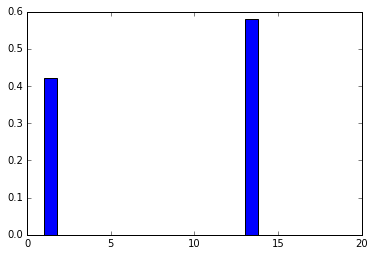

In [9]:
plt.bar(np.arange(20), data['doc_topic_dists'][0])